# Wczytanie danych oraz bibliotek

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("../data/to_model/new_york_listings_2024_to_model.csv");
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,718037328155265207,Rental unit in Queens · 5 bedrooms · 8 beds · ...,204539,Mark,Queens,Ridgewood,40.70262,-73.89800,Entire home/apt,471.0,...,2022-11-03,0.07,9,365,0,No License,No rating,5,8,2
1,5536638,Rental unit in Brooklyn · ★4.60 · 2 bedrooms ·...,28709982,Sidiq,Brooklyn,Williamsburg,40.72027,-73.95513,Entire home/apt,225.0,...,2023-09-13,0.49,5,90,7,No License,4.60,2,2,1
2,4605840,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,23788242,Suzanne,Brooklyn,Bedford-Stuyvesant,40.68670,-73.94856,Private room,80.0,...,2023-11-17,1.00,2,363,12,No License,4.93,1,1,1
3,594240338554500815,Rental unit in New York · 1 bedroom · 1 bed · ...,384559808,Best Inns USA,Manhattan,East Village,40.73221,-73.98689,Entire home/apt,83.0,...,2023-08-11,0.12,30,106,1,No License,No rating,1,1,1
4,26785,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,42273,Dani,Brooklyn,South Slope,40.66860,-73.98723,Entire home/apt,90.0,...,2022-05-31,2.90,3,188,0,No License,4.93,1,1,1


# Przygotowanie danych
- usuwamy kolumny: id, host_id, host_name, name, neighbourhood_group, neighbourhood, number_of_reviews_ltm (zostawiamy rewievs_per_month), bedrooms (zostawiamy beds)
- mapujemy kolumnę 
        - 'license' na 0 i 1 (0 - brak licencji, 1 - licencja)
        - 'baths' na int (jeśli nie jest podana to 0)
        - 'bedrooms' na int (jeśli nie jest podana to 0, a jeśli jest studio to 1)
        - 'rating' na float (jeśli nie ma to NaN)
- ordinal encoding dla 'room_type'
- kodujmey date 'last_review'
- uzywamy regresji linowej zeby uzupelnic NA w ratingu

### mapujemy

In [3]:
def lic_mapper(a):
    if a == "No License" or a == "Exempt":
        return 0
    else:
        return 1

def bath_mapper(a):
    if a == "Not specified":
        return 0
    else:
        return int(float(a))
def bedroom_mapper(a): # Uznałem, że posiadanie studio (czyli całe mieszkanie w jednym większym pokoju) to tak jakby była jedna sypialnia
    if a == "Studio":
        return 1
    else:
        return int(a)
def rating_mapper(a): # na razie tak może zostać
    if a == "New " or a == "No rating":
        return np.nan
    else:
        return float(a)
data["license"] = data["license"].map(lic_mapper)  # Jeśli ma licencję to 1, jeśli nie to 0
data["baths"] = data["baths"].map(bath_mapper)
data["bedrooms"] = data["bedrooms"].map(bedroom_mapper)
data["rating"] = data["rating"].map(rating_mapper)
data["last_review"] =  data["last_review"].map(np.datetime64) # Zmapowałem też date ostatniej opinii do przeznaczonego do tego typu

data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,718037328155265207,Rental unit in Queens · 5 bedrooms · 8 beds · ...,204539,Mark,Queens,Ridgewood,40.702620,-73.898000,Entire home/apt,471.0,...,2022-11-03,0.07,9,365,0,0,NaN,5,8,2
1,5536638,Rental unit in Brooklyn · ★4.60 · 2 bedrooms ·...,28709982,Sidiq,Brooklyn,Williamsburg,40.720270,-73.955130,Entire home/apt,225.0,...,2023-09-13,0.49,5,90,7,0,4.60,2,2,1
2,4605840,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,23788242,Suzanne,Brooklyn,Bedford-Stuyvesant,40.686700,-73.948560,Private room,80.0,...,2023-11-17,1.00,2,363,12,0,4.93,1,1,1
3,594240338554500815,Rental unit in New York · 1 bedroom · 1 bed · ...,384559808,Best Inns USA,Manhattan,East Village,40.732210,-73.986890,Entire home/apt,83.0,...,2023-08-11,0.12,30,106,1,0,NaN,1,1,1
4,26785,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,42273,Dani,Brooklyn,South Slope,40.668600,-73.987230,Entire home/apt,90.0,...,2022-05-31,2.90,3,188,0,0,4.93,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,726891322486149349,Condo in Brooklyn · ★4.87 · 3 bedrooms · 3 bed...,478704134,Milosz,Brooklyn,Bedford-Stuyvesant,40.686001,-73.943693,Entire home/apt,135.0,...,2023-01-10,0.97,1,262,1,0,4.87,3,3,1
16602,51828187,Home in Queens · ★4.69 · 1 bedroom · 1 bed · 1...,419863661,Yessica,Queens,Corona,40.745100,-73.864880,Private room,68.0,...,2023-10-16,2.68,2,180,16,0,4.69,1,1,1
16603,746852890077275772,Rental unit in The Bronx · ★4.73 · 1 bedroom ·...,471441645,Dyar,Bronx,Allerton,40.867770,-73.860180,Entire home/apt,100.0,...,2023-10-07,2.21,5,365,24,0,4.73,1,1,1
16604,14822309,Rental unit in New York · ★4.84 · 1 bedroom · ...,16978120,Chip,Manhattan,Harlem,40.830791,-73.949509,Private room,50.0,...,2023-12-10,0.21,4,42,1,0,4.84,1,1,1


### usuwamy kolumny

In [7]:
data = data.drop(["id", "name", "host_id", "host_name", "neighbourhood", "neighbourhood_group", "number_of_reviews_ltm", "bedrooms"], axis = 1)
data

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,NaN,8,2
1,40.720270,-73.955130,3,225.0,30,52,0.973081,0.49,5,90,0,4.60,2,1
2,40.686700,-73.948560,1,80.0,30,101,0.988430,1.00,2,363,0,4.93,1,1
3,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,0,NaN,1,1
4,40.668600,-73.987230,3,90.0,30,479,0.862102,2.90,3,188,0,4.93,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,0,4.87,3,1
16602,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,0,4.69,1,1
16603,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,0,4.73,1,1
16604,40.830791,-73.949509,1,50.0,30,19,0.993861,0.21,4,42,0,4.84,1,1


### ordinal encoding dla 'room_type'

In [5]:
room_type_map = {
    'Entire home/apt' : 3,
    "Hotel room": 2,
    "Private room": 1,
    "Shared room": 0
}
data["room_type"] = data["room_type"].map(room_type_map)
data

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,2022-11-03,0.07,9,365,0,0,NaN,5,8,2
1,40.720270,-73.955130,3,225.0,30,52,2023-09-13,0.49,5,90,7,0,4.60,2,2,1
2,40.686700,-73.948560,1,80.0,30,101,2023-11-17,1.00,2,363,12,0,4.93,1,1,1
3,40.732210,-73.986890,3,83.0,30,2,2023-08-11,0.12,30,106,1,0,NaN,1,1,1
4,40.668600,-73.987230,3,90.0,30,479,2022-05-31,2.90,3,188,0,0,4.93,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.686001,-73.943693,3,135.0,30,15,2023-01-10,0.97,1,262,1,0,4.87,3,3,1
16602,40.745100,-73.864880,1,68.0,30,16,2023-10-16,2.68,2,180,16,0,4.69,1,1,1
16603,40.867770,-73.860180,3,100.0,30,30,2023-10-07,2.21,5,365,24,0,4.73,1,1,1
16604,40.830791,-73.949509,1,50.0,30,19,2023-12-10,0.21,4,42,1,0,4.84,1,1,1


### Kodowanie daty 'last_review'

In [6]:
new_review = data["last_review"].apply(lambda x: x.timestamp())
a = new_review.min()
b = new_review.max()
new_review = new_review.apply(lambda x: (x - a) / (b - a))
data["last_review"] = new_review
data

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,0,NaN,5,8,2
1,40.720270,-73.955130,3,225.0,30,52,0.973081,0.49,5,90,7,0,4.60,2,2,1
2,40.686700,-73.948560,1,80.0,30,101,0.988430,1.00,2,363,12,0,4.93,1,1,1
3,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,1,0,NaN,1,1,1
4,40.668600,-73.987230,3,90.0,30,479,0.862102,2.90,3,188,0,0,4.93,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,1,0,4.87,3,3,1
16602,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,16,0,4.69,1,1,1
16603,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,24,0,4.73,1,1,1
16604,40.830791,-73.949509,1,50.0,30,19,0.993861,0.21,4,42,1,0,4.84,1,1,1


### inputacja nanow w ratingu

In [8]:
from sklearn.linear_model import LinearRegression
df_to_pred = data.copy()
# Te dane będziemy musieli uzupełnic
to_fill = df_to_pred[df_to_pred['rating'].isna()]
# Na tych danych wyszkolimy nasz LinearRegression model
filled = data[df_to_pred.index.map(lambda x: x not in to_fill.index.to_numpy()).to_numpy()]
#
to_fill = to_fill.reset_index(drop = True)
filled = filled.reset_index(drop = True)
# Szkolimy model regresji liniowej
X = filled.drop("rating", axis = 1)
y = filled["rating"]
lr = LinearRegression()
lr.fit(X, y)
new_rating = lr.predict(to_fill.drop("rating", axis = 1))
pd.Series(new_rating)
# Wypełniamy nany
to_fill["rating"] = new_rating

In [9]:
#sprawdzamy
to_fill['rating'].isna().sum()

0

In [12]:
# Pozostaje zatem przepisac ramke jako nowa df
df = pd.concat([to_fill, filled], axis = 0).reset_index(drop = True)
df

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,4.678690,8,2
1,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,0,4.742355,1,1
2,40.684210,-73.907890,1,150.0,30,1,0.594097,0.02,1,0,0,4.670132,1,1
3,40.874690,-73.901690,1,200.0,30,1,0.481700,0.01,2,0,0,4.593371,1,1
4,40.671320,-73.960900,1,32.0,30,1,0.783707,0.03,1,322,0,4.679929,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.745330,-73.919580,1,55.0,30,3,0.983943,0.21,1,364,0,5.000000,1,1
16602,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,0,4.870000,3,1
16603,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,0,4.690000,1,1
16604,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,0,4.730000,1,1


## transforamcje danych
Ostatecznie:
- uzywamy PYOD do usuniecia outlierow 
- uzywami yeo-johnson (oprocz latitude, longitude, room_type, license) i pozniej min_max_scaler

### Usuwanie outlierów

In [17]:
# oprocz latitude, longtitude, room_type (kategoryczna), license (binarna)
cols = df.columns.to_numpy()
cols_to_pyod = [cols for cols in df.columns if cols not in ["latitude", "longitude", "room_type", "license"]]

from pyod.models.knn import KNN
clf = KNN(contamination=0.04)
clf.fit(df[cols_to_pyod])
df['outliers'] = clf.labels_
df['outliers'].value_counts()

outliers
0    15941
1      665
Name: count, dtype: int64

In [18]:
# usuwamy outliery
df = df[df['outliers'] == 0]
df = df.drop('outliers', axis = 1)
df

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,4.678690,8,2
1,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,0,4.742355,1,1
2,40.684210,-73.907890,1,150.0,30,1,0.594097,0.02,1,0,0,4.670132,1,1
3,40.874690,-73.901690,1,200.0,30,1,0.481700,0.01,2,0,0,4.593371,1,1
4,40.671320,-73.960900,1,32.0,30,1,0.783707,0.03,1,322,0,4.679929,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.745330,-73.919580,1,55.0,30,3,0.983943,0.21,1,364,0,5.000000,1,1
16602,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,0,4.870000,3,1
16603,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,0,4.690000,1,1
16604,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,0,4.730000,1,1


### yeo-johnson
bez latitude, longitude, room_type, license

In [20]:
cols_to_johnson = [cols for cols in df.columns if cols not in ["latitude", "longitude", "room_type", "license"]]

from scipy.stats import yeojohnson
# korzystanie z yeo_johhsona
df_yeo = df.copy()
for col in cols_to_johnson:
    df_yeo[col], _ = yeojohnson(df[col])
df_yeo

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,4.349581,9.727349,0.677335,89664.099417,0.065720,1.038272,55.411318,0,2.761742e+08,0.382909,0.628101
1,40.732210,-73.986890,3,3.434738,9.727349,1.059243,195177.092109,0.107960,1.151104,25.683720,0,3.180145e+08,0.320938,0.480012
2,40.684210,-73.907890,1,3.767077,9.727349,0.677335,1703.996897,0.019634,0.529391,0.000000,0,2.709542e+08,0.320938,0.480012
3,40.874690,-73.901690,1,3.920853,9.727349,0.677335,325.278516,0.009908,0.725473,0.000000,0,2.280323e+08,0.320938,0.480012
4,40.671320,-73.960900,1,2.854393,9.727349,0.677335,21721.564540,0.029185,0.529391,51.299637,0,2.769376e+08,0.320938,0.480012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.745330,-73.919580,1,3.190871,9.727349,1.324002,241739.557378,0.175758,0.529391,55.317979,0,5.541467e+08,0.320938,0.480012
16602,40.686001,-73.943693,3,3.709492,9.727349,2.530828,108501.726723,0.513213,0.529391,45.172859,0,4.200070e+08,0.373762,0.480012
16603,40.745100,-73.864880,1,3.317912,9.727349,2.581095,233408.940046,0.782119,0.725473,35.790661,0,2.832152e+08,0.320938,0.480012
16604,40.867770,-73.860180,3,3.541716,9.727349,3.068367,227803.107791,0.735039,0.941464,55.411318,0,3.094645e+08,0.320938,0.480012


### min_max_scaler

In [21]:
from sklearn.preprocessing import MinMaxScaler

# WSZYSTKIE kolumny
df_final = df_yeo.copy()
scaler = MinMaxScaler()
df_final[df_final.columns] = scaler.fit_transform(df_final[df_final.columns])
df_final

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,0.492428,0.656185,1.000000,0.758784,0.126667,0.000000,0.309020,0.051765,0.737167,1.000000,0.0,0.498299,0.985259,0.757568
1,0.564453,0.490405,1.000000,0.452508,0.126667,0.086282,0.672663,0.090941,0.900616,0.463510,0.0,0.573815,0.000000,0.578954
2,0.447617,0.637740,0.333333,0.563770,0.126667,0.000000,0.005873,0.009021,0.000000,0.000000,0.0,0.488878,0.000000,0.578954
3,0.911261,0.649303,0.333333,0.615252,0.126667,0.000000,0.001121,0.000000,0.284046,0.000000,0.0,0.411410,0.000000,0.578954
4,0.416242,0.538876,0.333333,0.258218,0.126667,0.000000,0.074862,0.017879,0.000000,0.925797,0.0,0.499677,0.000000,0.578954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,0.596388,0.615938,0.333333,0.370865,0.126667,0.146097,0.833137,0.153823,0.000000,0.998316,0.0,1.000000,0.000000,0.578954
16602,0.451976,0.570967,1.000000,0.544492,0.126667,0.418746,0.373943,0.466805,0.000000,0.815228,0.0,0.757897,0.839836,0.578954
16603,0.595828,0.717954,0.333333,0.413397,0.126667,0.430102,0.804426,0.716210,0.284046,0.645909,0.0,0.511007,0.000000,0.578954
16604,0.894417,0.726720,1.000000,0.488323,0.126667,0.540188,0.785106,0.672544,0.596931,1.000000,0.0,0.558384,0.000000,0.578954


ostateczna nazwa danych po wszytski transformacjach to df_final

# Modele

## 1. K-means

uznalam ze robiles to juz ostatnio, wiec chyba latwiej jak ten ty zrobisz

## 2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [25]:
from sklearn.cluster import DBSCAN

### 2.1 strojenie parametrów

#### eps
odnosi się do maksymalnej odległości między dwoma punktami, które mogą być uznane za sąsiadów; wplywa na to ile punktow jest unzawanych za czesc klastra

Uzyjemy metody k-nearest neighbors (KNN)

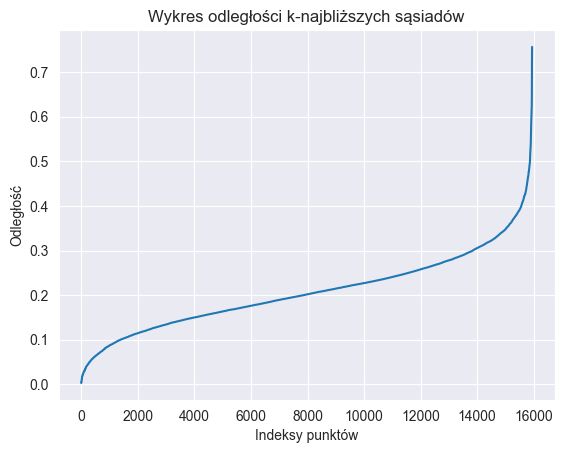

In [22]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_final)
distances, indices = nbrs.kneighbors(df_final)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.title("Wykres odległości k-najbliższych sąsiadów")
plt.xlabel("Indeksy punktów")
plt.ylabel("Odległość")
plt.show()

Szukamy punktu gdzie nastepuje nagly skok w odleglosciach (szybko rosnie do gory).

U na będzie to około między 0.3 a 0.4


#### min_samples
Określa minimalną liczbę punktów w sąsiedztwie punktu centralnego (core point).

Zazwyczaj jego wartość ustawia sie na wartosc wieksza niz wymiarowosc zbioru danych. 
Zatem, skoro nasz dane są 14-wymiarowe to min_samples powinno wynosic co najmniej 15.

#### strojenie

In [54]:
# UWAGA DLUGO SIE WYKONUJE - ok.18min
from sklearn.metrics import silhouette_score
# eps_values to 0.3, 0.35,0.4
eps_values = [0.3, 0.35, 0.4]
min_samples_values = np.arange(15, 25, 1)
best_score = -1
best_eps = 0
best_min_samples = 0

for eps in eps_values:
    for min_sample in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(df_final)
        # ignorowanie wynikow z jednym klastrem
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df_final, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_sample

print(f"Best score: {best_score}, eps: {best_eps}, min_samples: {best_min_samples}")

Best score: 0.0570646390603561, eps: 0.4, min_samples: 20


In [53]:
# UWAGA DLUGO SIE WYKONUJE - ok.18min
from sklearn.metrics import silhouette_score
# eps_values to 0.3-1 co 0.05
eps_values = np.arange(0.3, 1, 0.05)
min_samples_values = np.arange(15, 25, 1)
best_score = -1
best_eps = 0
best_min_samples = 0

for eps in eps_values:
    for min_sample in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(df_final)
       # ignorowanie wynikow z jednym klastrem
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df_final, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_sample

print(f"Best score: {best_score}, eps: {best_eps}, min_samples: {best_min_samples}")

Best score: 0.2335570384327045, eps: 0.8999999999999999, min_samples: 15


Co ciekawe gdy patrzymy na przedziale eps 0.3-0.4 (czyli takim jaki powinien byc wedlug wyznaczania eps metoda KNN) to najlpeszy wynik (wg silhouette score) jest dla eps=0.4 min_samples=20 - wynik: 0.057064

jednak dla wiekszych przedziałow (gdy patrzymy juz do 1), najlepszy wynik wychodzi dla eps=0.8, min_samples=15 - wynik: 0.23355704

Dlatego sprawdzimy oba te wyniki

### 2.2 model

In [55]:
# dla eps=0.4
dbscan_eps_4 = DBSCAN(eps=0.4, min_samples=20)
clusters_dbscan_4 = dbscan_eps_4.fit_predict(df_final)

# dla eps=.8
dbscan_eps_8 = DBSCAN(eps=0.8, min_samples=15)
clusters_dbscan_8 = dbscan_eps_8.fit_predict(df_final)

### 2.3 wyniki

#### wskaznik Silhouette

In [56]:
from sklearn.metrics import silhouette_score

score_4 = silhouette_score(df_final, clusters_dbscan_4)
score_8 = silhouette_score(df_final, clusters_dbscan_8)

print(f"Silhouette score dla eps=0.4 i min_smaples=8: {score_4}")
print(f"Silhouette score dla eps=0.8 i min_smaples=3: {score_8}")

Silhouette score dla eps=0.4 i min_smaples=8: 0.0570646390603561
Silhouette score dla eps=0.8 i min_smaples=3: 0.193179172139691


ewidentnie widizmy tu ze dla eps=0.8, min_samples=3 wynik jest lepszy

#### wizualizacja

In [44]:
def plot_clusters(X, model, title="", **kwargs):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np)
    else:
        y_pred = model.predict(X)
    plt.scatter(X[:,0],X[:,1],c=y_pred, cmap='viridis', **kwargs)
    plt.title(title)
    plt.show()

C:\Users\domin\AppData\Local\Temp\ipykernel_27516\3875846755.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


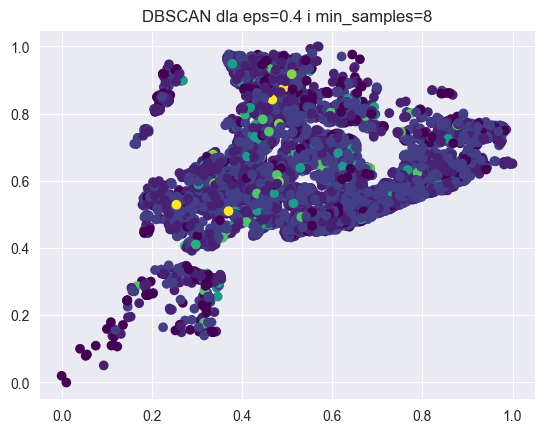

In [45]:
#wykres dla eps=0.4 dla wszytskich zmiennych naraz
plot_clusters(df_final.to_numpy(), dbscan_eps_4, "DBSCAN dla eps=0.4 i min_samples=8")


ogolnie te wizualizacje cos mi nei dzialaja i pozniej sie nimi jeszcze zajme

#### indeks Daviesa-Bouldina
Niskie wartości tego indeksu sugerują lepsze klastrowanie, co oznacza, że klastry są dobrze oddzielone i mają niską wariancję wewnętrzną.

In [57]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score_4 = davies_bouldin_score(df_final, clusters_dbscan_4)
davies_bouldin_score_8 = davies_bouldin_score(df_final, clusters_dbscan_8)

print(f"Indeks Daviesa-Bouldina dla eps=0.4 i min_smaples=20: {davies_bouldin_score_4}")
print(f"Indeks Daviesa-Bouldina dla eps=0.8 i min_smaples=15: {davies_bouldin_score_8}")

Indeks Daviesa-Bouldina dla eps=0.4 i min_smaples=8: 2.008856764154024
Indeks Daviesa-Bouldina dla eps=0.8 i min_smaples=3: 1.9062054177808954


Wynik dla eps=0.8, min_samples=3 jest lepszy -> czyli tak samo jak w shilouette score